## Setup

In [1]:
import sys
sys.path.append("../../ELDR-reproduction/Code")
sys.path.append("../../ELDR-reproduction/scvis/lib/scvis")

## ELDR Iris

In [19]:
# Chosen using results from Iris-K
epsilon = 0.75
k = 1

input_dim = 4
num_clusters = 3
num_classes = 3

model_file = "../../ELDR-reproduction/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

feature_names = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]
import csv
import json
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_change
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


In [20]:
# Load Data & Configuration

x = pd.read_csv("../../Data/iris/X.tsv", sep="\t").values

y = pd.read_csv("../../Data/iris/y.tsv", sep="\t").values


with open("../../ELDR-reproduction/Iris/vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [22]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})

INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


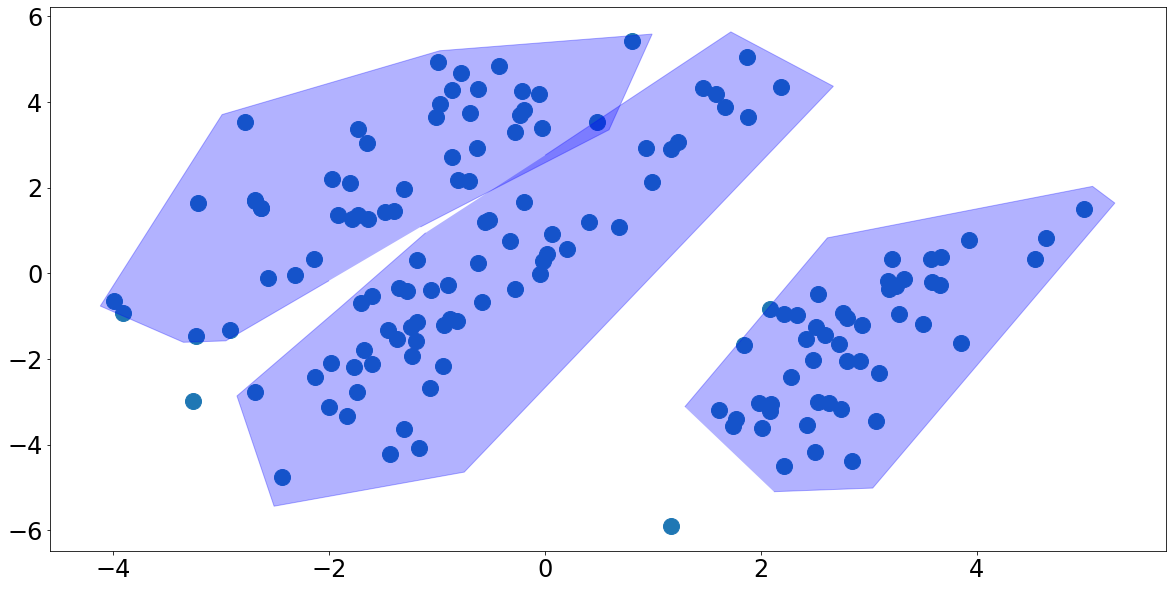

In [26]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

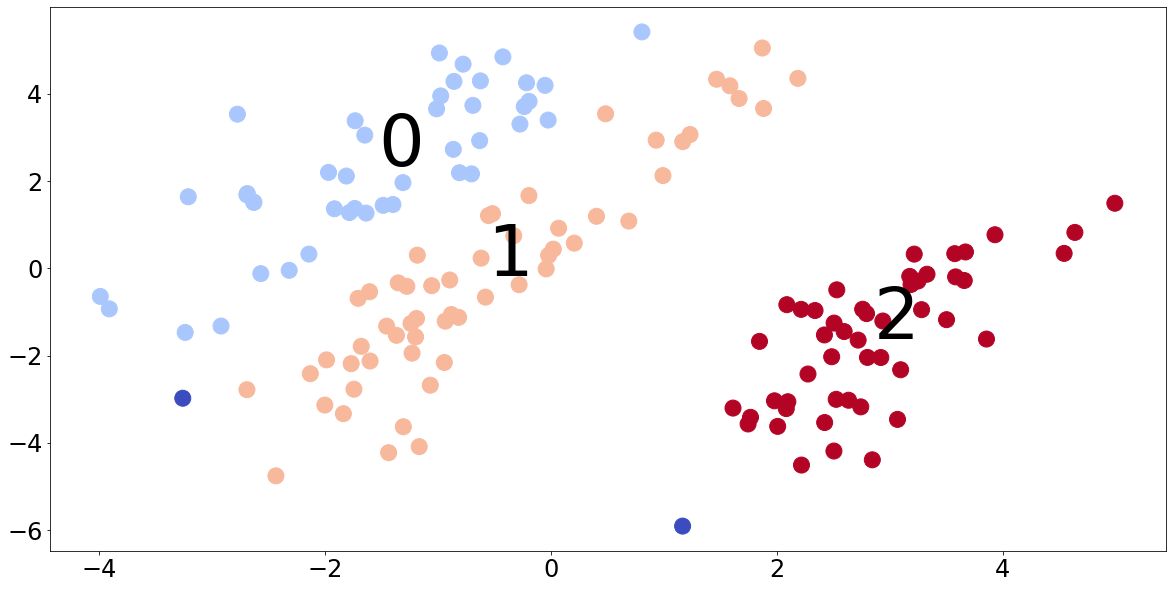

In [27]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "iris-rep.png")


In [28]:
# Inspect the correlation between cluster and class

confusion  = np.zeros((num_clusters, num_classes))
for i in range(y.shape[0]):
    if labels[i] != -1.0:
        confusion[int(labels[i]), int(y[i])] += 1
    
print(confusion)

[[ 0.  5. 38.]
 [ 0. 44. 12.]
 [48.  0.  0.]]


INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


/content/ELDR/Code/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)


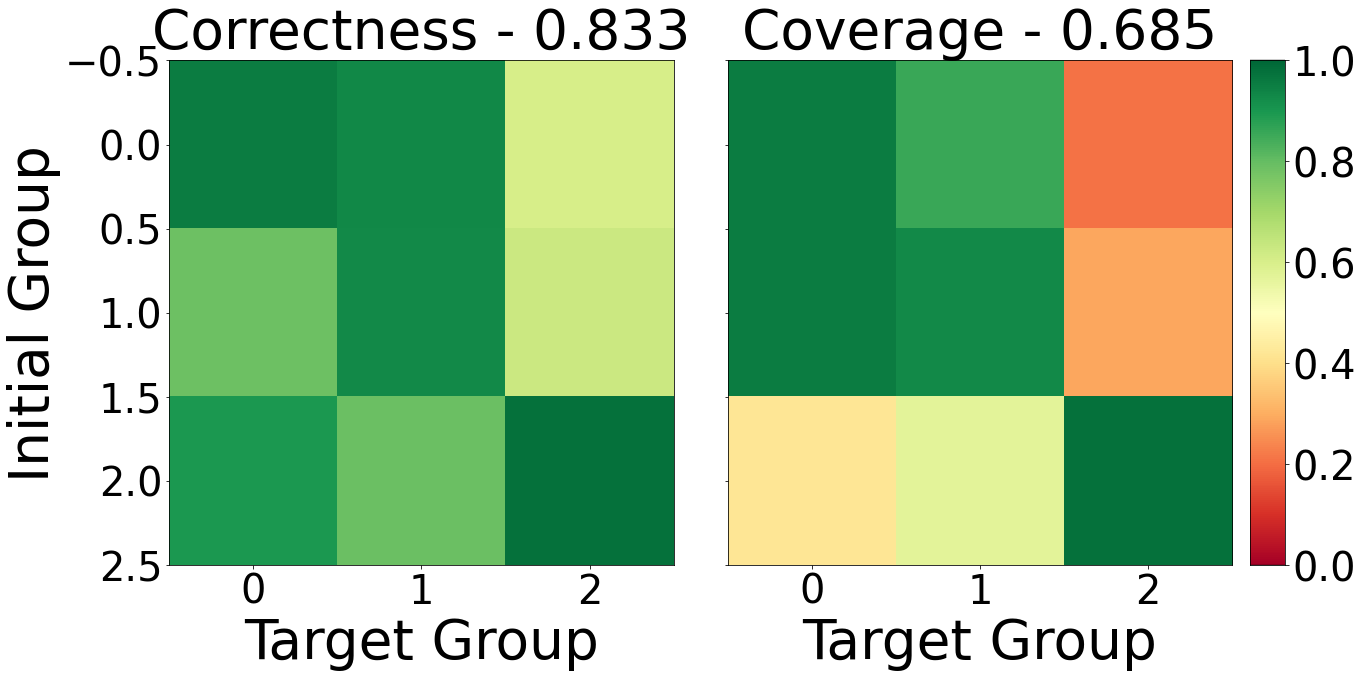

INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


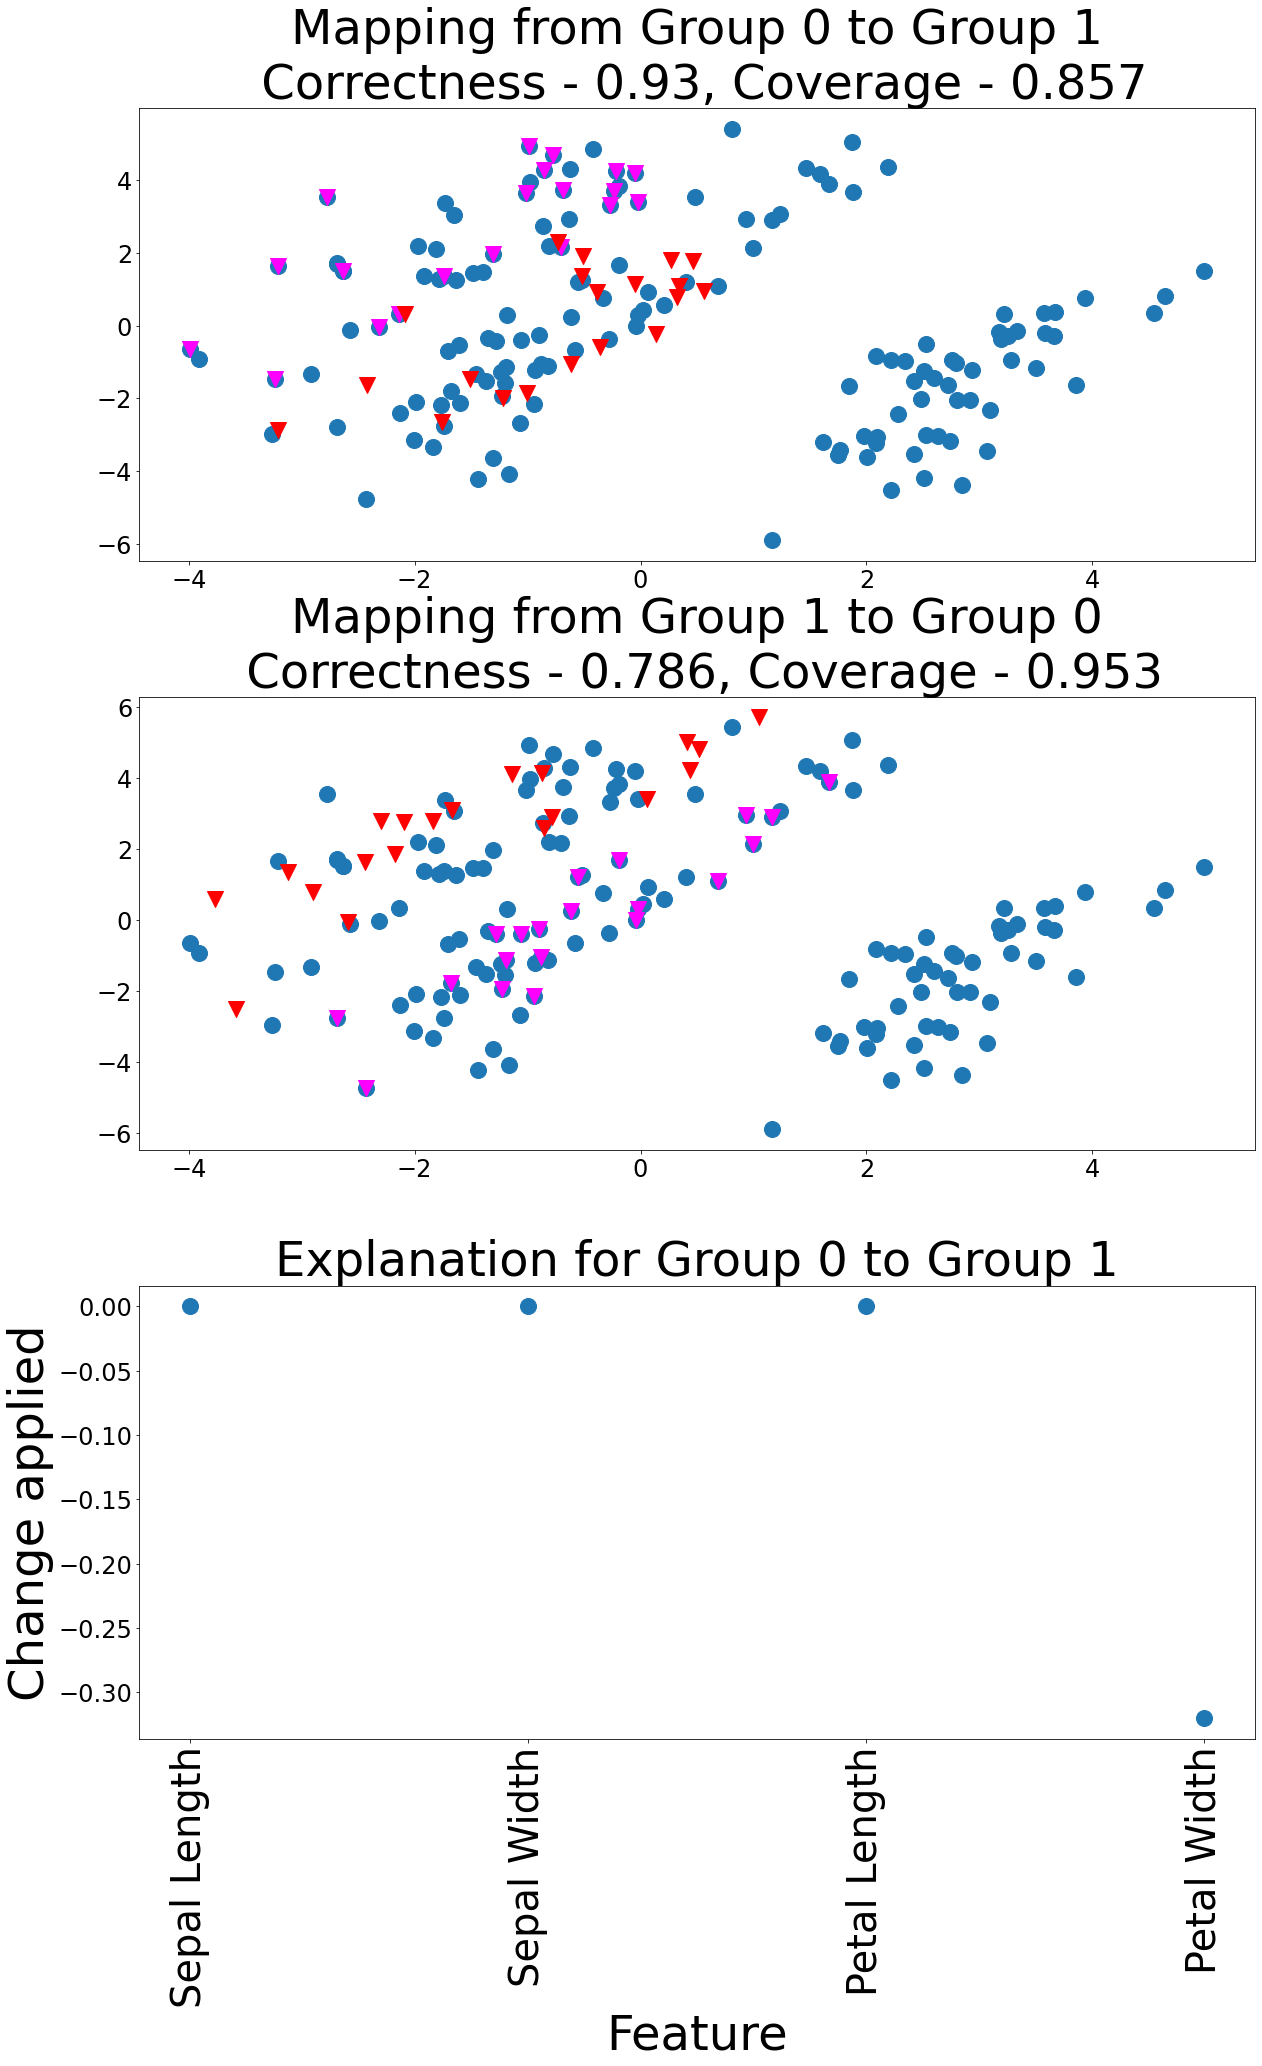

INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


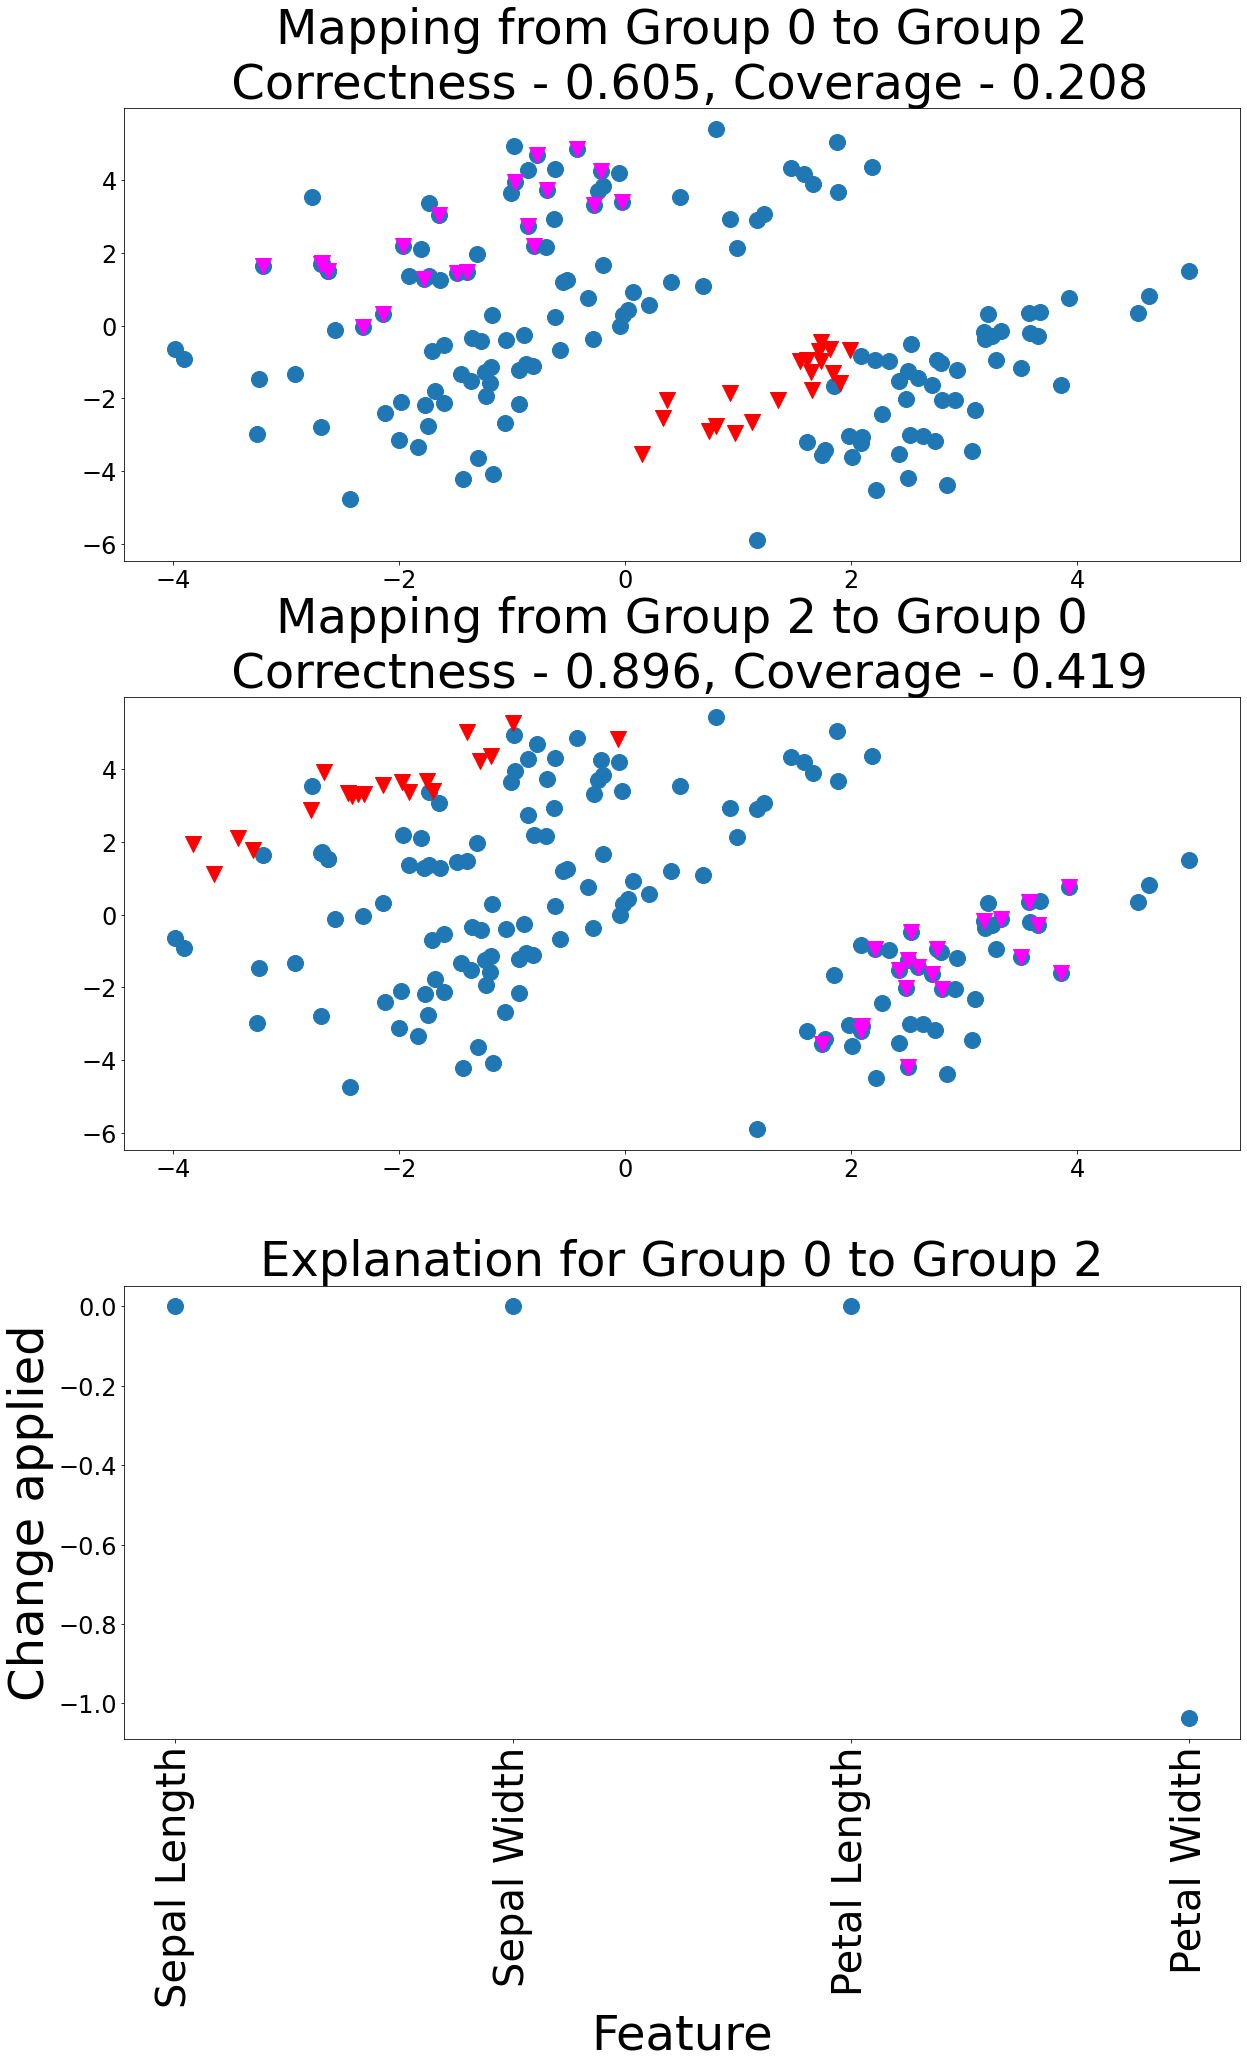

INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


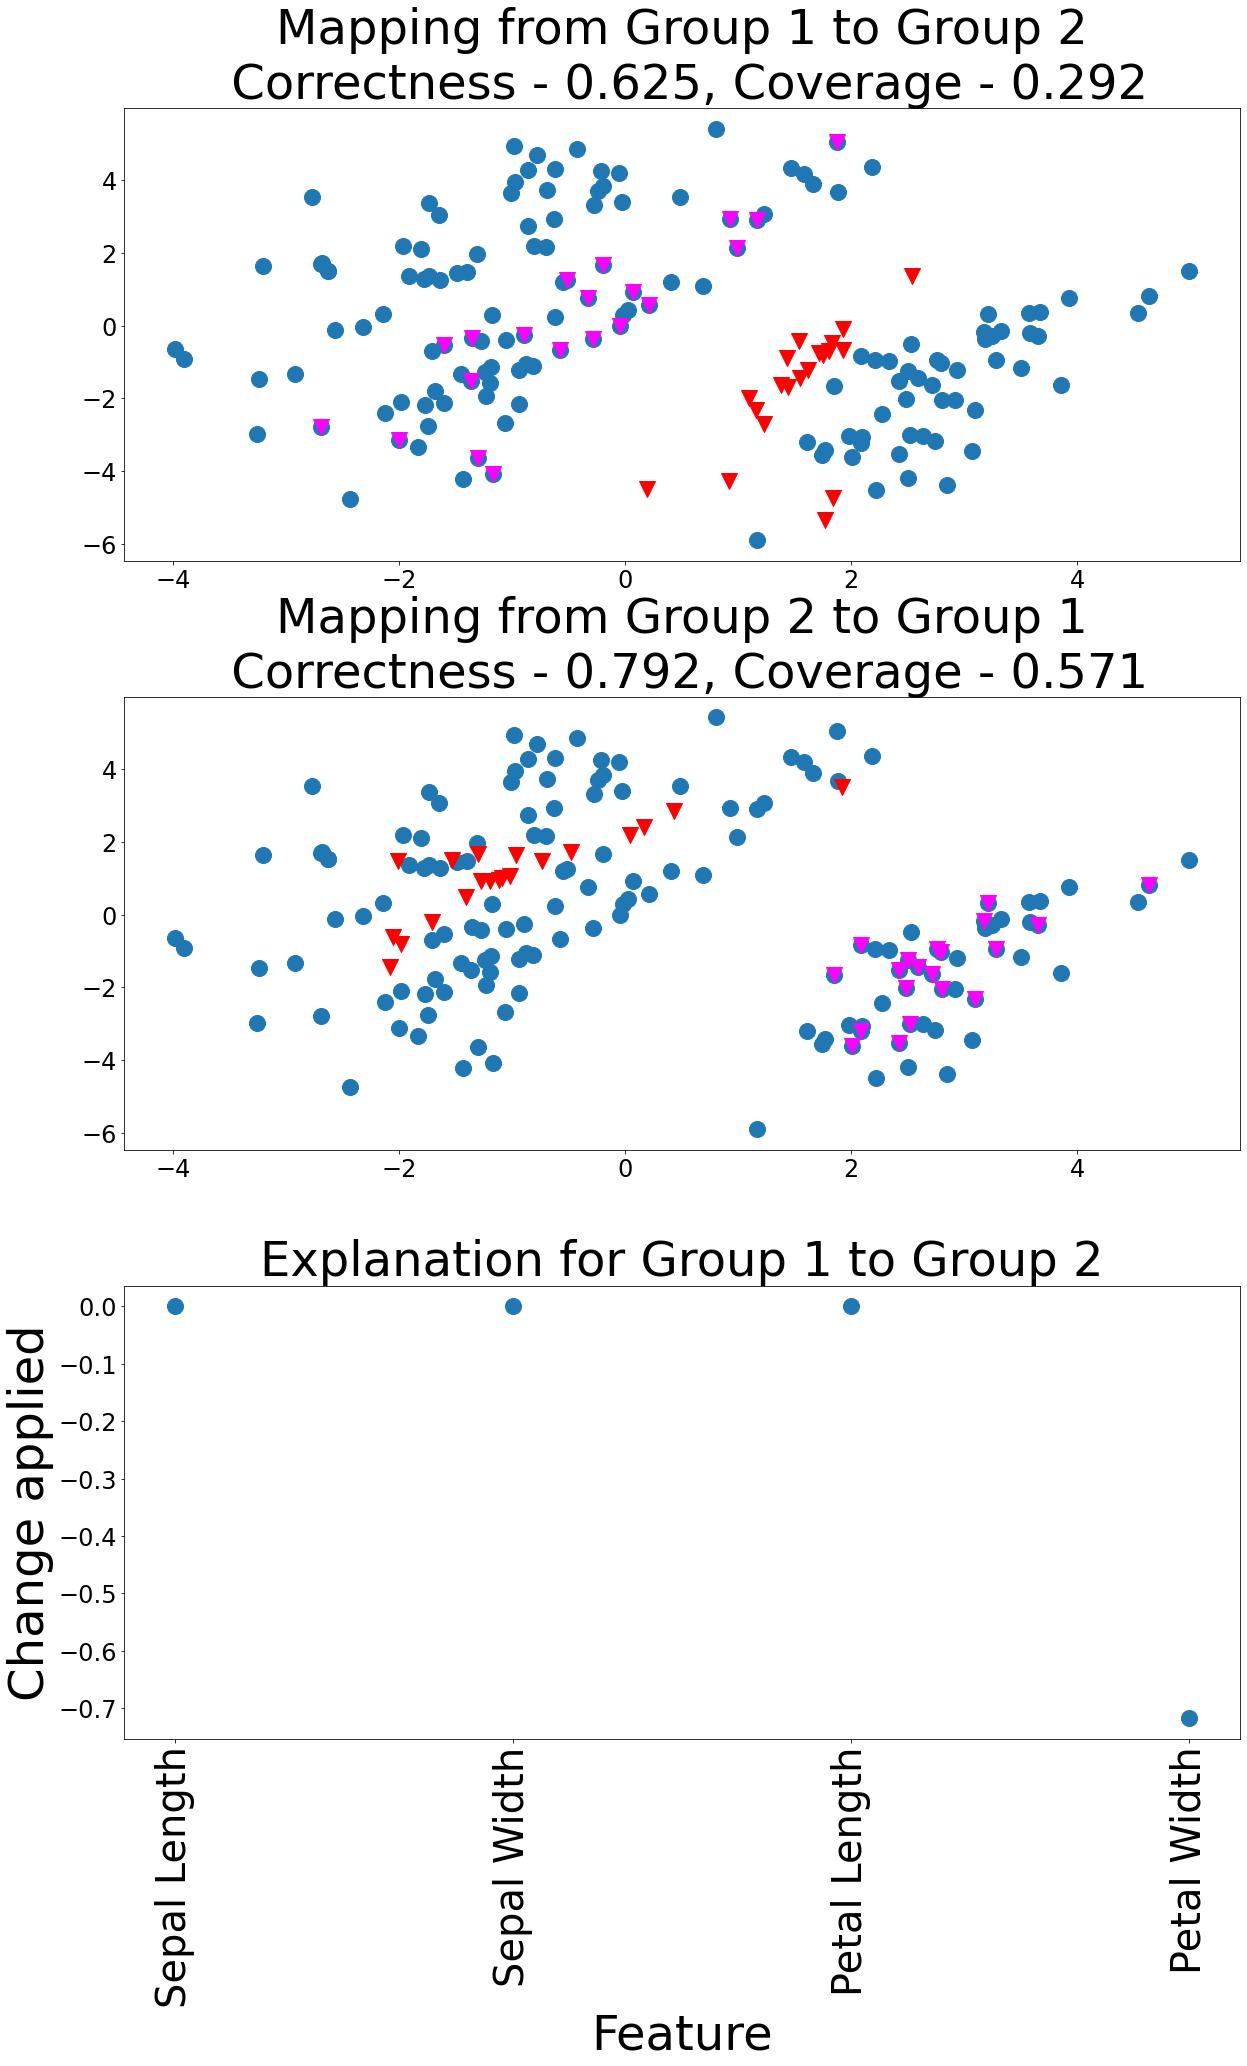

In [29]:
# Evaluate the explanations

deltas = np.load("../../ELDR-reproduction/Iris-K/deltas" + str(k) + ".npy")

a, b = metrics(load_model, x, indices, deltas, epsilon, k = k)

plot_metrics(a, b, name = "iris-metrics.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 1, k = k, name = "iris-0to1.png", num_points = 20, feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 2, k = k,  name = "iris-0to2.png", num_points = 20, feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 2, k = k,  name = "iris-1to2.png", num_points = 20, feature_names = feature_names)


In [30]:
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
K = range(1,num_clusters+1)
# out = np.zeros((len(K), 4))

# best_deltas = np.zeros((num_clusters - 1, input_dim))

# # Evaluate TGTs
# for c,k in enumerate(K):
#   best_val = 0.0
#   for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
#       for trial in range(3):

#           deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
#           a, b = metrics(load_model, x, indices, deltas, epsilon, k = k) 

#           val = np.mean(a)

#           if val > best_val:
#               best_deltas = deltas
#               best_val = val
#               out[c, 0] = best_val
#               out[c, 1] = np.mean(b)
# Evaluate DBMs
exp_mean = np.zeros((num_clusters - 1, input_dim))
for i in range(num_clusters - 1):
    exp_mean[i, :] = means[i + 1] - means[0]

# for c,k in enumerate(K):
#     a, b = metrics(load_model, x, indices, exp_mean, epsilon, k = k)
    # out[c, 2] = np.mean(a)
    # out[c, 3] = np.mean(b)

# print(out)

In [31]:
def eval_classification(X, labels, deltas, dbms, k):

  from sklearn.linear_model import LogisticRegression
  from sklearn.metrics import accuracy_score

  num_clusters = 3
  tgt_features = [np.argpartition(deltas[i],-k)[-k:].tolist() for i in range(num_clusters - 1)]
  dbm_features = [np.argpartition(dbms[i],-k)[-k:].tolist() for i in range(num_clusters -1)]

  ##### TGT ######

  # train classifiers
  clfs = []
  for c, idxs in enumerate(tgt_features):
    kx = X[:,idxs]
    ky = (labels == c).astype(int)
    clf = LogisticRegression().fit(kx, ky)
    clfs.append(clf)

  # predict using one-vs-rest ensemble
  preds = []
  for i in range(x.shape[0]):
    probs = []
    for c in range(num_clusters-1):
      pred = clfs[c].predict_proba(x[i, tgt_features[c]].reshape(1, -1))
      probs.append(pred[:,1][0])
    preds.append(np.argmax(probs))

  tgt_acc = accuracy_score(labels, preds)
  
  ##### DBM ######
  clfs = []
  for c, idxs in enumerate(dbm_features):
    kx = X[:,idxs]
    ky = (labels == c).astype(int)
    clf = LogisticRegression().fit(kx, ky)
    clfs.append(clf)

  # predict using one-vs-rest ensemble
  preds = []
  for i in range(x.shape[0]):
    probs = []
    for c in range(num_clusters-1):
      pred = clfs[c].predict_proba(x[i, dbm_features[c]].reshape(1, -1))
      probs.append(pred[:,1][0])
    preds.append(np.argmax(probs))
  
  dbm_acc = accuracy_score(labels, preds)

  return [tgt_acc, dbm_acc]

In [32]:
for i,l in np.ndenumerate(labels):
  if l == -1: 
    labels[i[0]] = 0
    continue
  if l == 0: 
    labels[i[0]] = 0
    continue
  if l == 1: 
    labels[i[0]] = 1
    continue
  if l == 2: 
    labels[i[0]] = 2
    continue

In [33]:
unique, counts = np.unique(labels, return_counts=True)

In [34]:
counts

array([45, 56, 48])

In [37]:
tgt_res = []
dbm_res = []
num_features = range(1,input_dim + 1)
for k in num_features:
  res = eval_classification(x, labels, deltas, exp_mean, k)
  tgt_res.append(res[1])
  dbm_res.append(res[0])

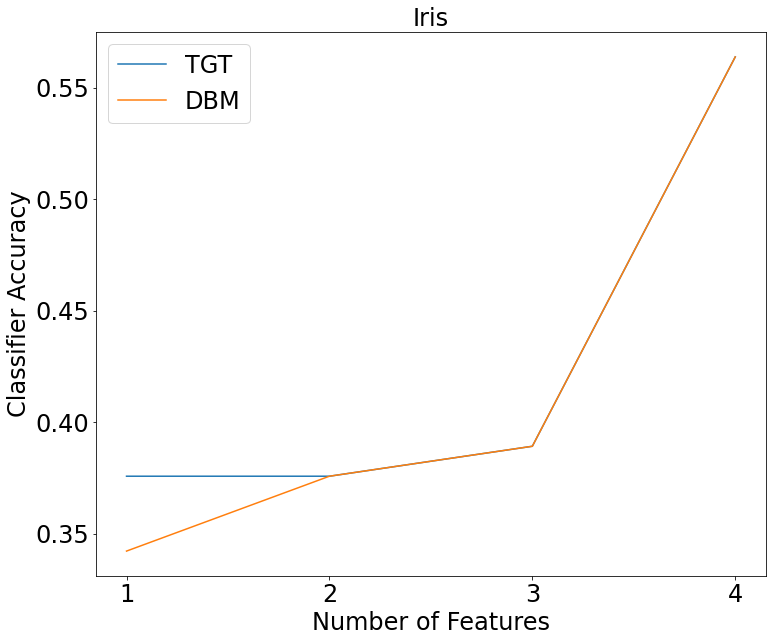

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.plot(num_features, tgt_res, label='TGT')
plt.plot(num_features, dbm_res, label='DBM')
plt.xticks(num_features)
plt.title('Iris',  fontsize=24)
plt.xlabel('Number of Features', fontsize=24)
plt.ylabel('Classifier Accuracy', fontsize=24)
plt.legend(prop={'size': 24})
plt.show()